# Predicting Match Results in the Portuguese First League of Football

The goal of this project is to predict the results of football matches in the Portuguese first league. The objective is to model:

* Attacking strength
* Defensive strength
* Home advantage

for each team in the league. Various models should be tested, and relevant conclusions should be drawn.

# **Model I - Poisson Distribution**

This section is based on the following paper:  
* *Modelling Association Football Scores - M. J. Mahers*
* [http://www.90minut.pl/misc/maher.pdf](http://www.90minut.pl/misc/maher.pdf)  

In this section, we will explain how to build a model to predict football scores using the Poisson distribution. By the end, we will discover that the model is quite simplistic and has certain difficulties in some areas. However, the model provides a good starting point for our project.

## **Dataset**

Our model's operation is based on predicting the number of goals scored and conceded by each team when they play against each other, based on their historical performance. To achieve this, we will use a dataset of matches from the Portuguese First League of Football from the website [https://www.football-data.co.uk/portugalm.php](https://www.football-data.co.uk/portugalm.php), the dataset used refers to the 2021/22 championship.

In [1]:
import pandas as pd

df = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/P1.csv")
df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,06/08/2021,Sp Lisbon,Vizela,3,0,H
1,07/08/2021,Arouca,Estoril,0,2,A
2,07/08/2021,Moreirense,Benfica,1,2,A
3,07/08/2021,Maritimo,Sp Braga,0,2,A
4,08/08/2021,Guimaraes,Portimonense,0,1,A
...,...,...,...,...,...,...
301,14/05/2022,Maritimo,Portimonense,0,1,A
302,14/05/2022,Porto,Estoril,2,0,H
303,14/05/2022,Sp Lisbon,Santa Clara,4,0,H
304,15/05/2022,Famalicao,Sp Braga,3,2,H


Currently, we have the team names (***HomeTeam*** and ***AwayTeam***), the number of goals scored by the home team at the end of the match (**FTHG**, *final time home goals*), the number of goals scored by the away team at the end of the match (**FTAG**, *final time away goals*), and who won (**FTR**, *final team result* where H is *HomeTeam* and A is *AwayTeam*).

## **Home Advantage I**

Let's begin by analyzing the basic information we have in our dataset. We'll start with the average number of goals scored.

In [2]:
df[["FTHG", "FTAG"]].mean()

FTHG    1.431373
FTAG    1.205882
dtype: float64

In [3]:
meanFTHG = df[["FTHG"]].mean()
meanFTAG = df[["FTAG"]].mean()
rel = float(meanFTHG)/float(meanFTAG)
print(rel)

1.1869918699186992


C:\Users\pedro\AppData\Local\Temp\ipykernel_13912\577232937.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rel = float(meanFTHG)/float(meanFTAG)


On average, the home team scores about `18.70%` more goals than the away team, so our model should take home advantage into consideration.  
Next, we'll plot the distribution of goals scored by the home and away teams.

Text(0.5, 1.0, 'Number of goals scored per game')

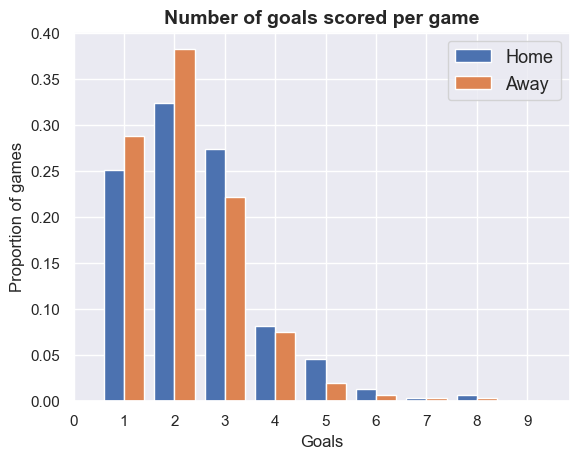

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
max_goals = 10
plt.hist(df[["FTHG", "FTAG"]].values, range(max_goals), label=["Home", "Away"], density=True)
plt.xticks([i - 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of games")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of goals scored per game", size=14, fontweight="bold")

The distribution appears quite similar to a *Poisson Distribution*. We can confirm our assumption by plotting the number of goals obtained from the *Poisson Distribution* along with the average number of goals we calculated above.

Text(0.5, 1.0, 'Number of goals scored per game')

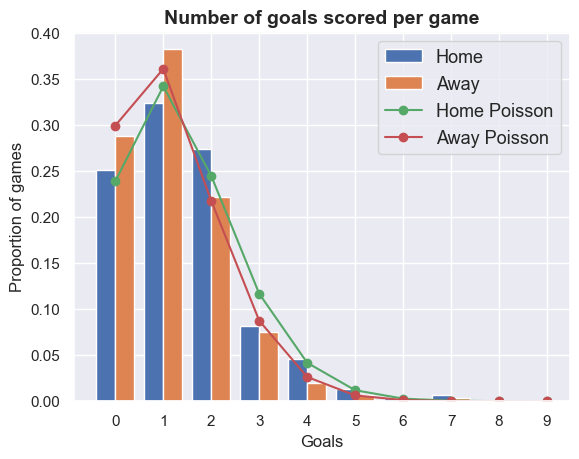

In [5]:
import numpy as np
from scipy.stats import poisson

home_poisson = poisson.pmf(range(10), df["FTHG"].mean())
away_poisson = poisson.pmf(range(10), df["FTAG"].mean())

max_goals = 10
plt.hist(df[["FTHG", "FTAG"]].values, range(max_goals), label=["Home", "Away"], density=True)
plt.plot([i - 0.5 for i in range(1, max_goals + 1)], home_poisson, linestyle="-", marker="o", label="Home Poisson",)
plt.plot([i - 0.5 for i in range(1, max_goals + 1)], away_poisson, linestyle="-", marker="o", label="Away Poisson",)
plt.xticks([i - 0.5 for i in range(1, max_goals + 1)], [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of games")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of goals scored per game", size=14, fontweight="bold")

It's not perfect, but it's a start. With this, it's possible to approximate the number of goals scored using a Poisson distribution.

## **Prediction Model**

To create the prediction model, we need information about the expected number of goals each team will score against the others.  
For this, we assume that the number of goals scored by a team is a function of its attacking strength and the defensive strength of the opposing team. Thus, teams with a stronger attack should score more goals, while teams with weaker defenses are more likely to concede goals.  
Additionally, we must consider the home-field advantage when a team plays at home. Therefore, our model will take the following form:

$goals\_home = home\_advantage + home\_attack + defence\_away$    
$goals\_away = away\_attack + defence\_home$  

Now, we need to determine the parameters for our model.

### **Model Parameters**

To determine the best parameters for attack and defense, we need to define a value to optimize. For this, we will use the *Maximum Likelihood Estimation* method, which aims to find the parameters that best fit and predict results based on historical data. This approach helps generate more reliable predictions by leveraging past match outcomes.

In this case, calculating the *likelihood* involves a large number of small calculations. Therefore, we will maximize the *log-likelihood* instead, allowing us to sum the logs of all *likelihoods* rather than multiplying small values, which could introduce errors and inaccuracies.

Since the *scipy* library in Python provides an optimizer that minimizes values instead of maximizing the *log-likelihood*, we will minimize the negative *log-likelihood*.

The function that computes the *log-likelihood* is as follows:

In [6]:
def log_likelihood(goals_home_observed, goals_away_observed, home_attack, home_defence, away_attack, away_defence, home_advantage,):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)
    if goal_expectation_home < 0 or goal_expectation_away < 0:
        return 10000    
    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    log_llk = np.log(home_llk) + np.log(away_llk)
    return -log_llk

Initially, we provide the model with the attack, defense, and home advantage parameters to calculate the number of goals each team is expected to score. Then, if the number of goals is less than 0, we return a very high value so that the *optimizer* detects that the tested values are incorrect and do not fit the real data. If the number of goals is 0 or higher, we use the Poisson distribution to determine the number of goals scored by each team. Next, the obtained values are converted to *log* and summed. Finally, we return the negative *log-likelihood*.

After defining the function, we need to provide it to the *optimizer*. The *optimizer* is configured as follows:

1. Extract the teams that will be used to fit the model.  
2. Create default parameters for the model, which the *optimizer* will use as starting points.  
3. Define a function called `_fit`, which calculates the logarithm of the expected value.  
4. Set the *optimizer* to stop searching for a solution after 100 attempts.  
5. Impose a constraint on the *optimizer*: the sum of the attack parameters must equal the total number of teams.  
6. Run the *optimizer* to find the best-fitting parameters for the model and dataset.  

In [7]:
from scipy.optimize import minimize

def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)
    params = np.concatenate((
            # Força atacante
            np.random.uniform(0.5, 1.5, (n_teams)),
            # Força defensiva
            np.random.uniform(0, -1, (n_teams)), 
            # Vantagem de jogar em casa
            [0.25],))

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"], row["FTAG"],
                attack_params[row["HomeTeam"]], 
                defence_params[row["HomeTeam"]], 
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,)
            llk.append(tmp)

        return np.sum(llk)

    options = {"maxiter": 100,"disp": False,}
    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]
    res = minimize(_fit, params, args=(df, teams), constraints=constraints, options=options,)
    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv"],
            res["x"],))
    print("Log Likelihood: ", res["fun"])
    return model_params

model_params = fit_poisson_model()

C:\Users\pedro\AppData\Local\Temp\ipykernel_13912\1010459298.py:8: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk)


Log Likelihood:  823.9346111218349
